The idea of this notebooks is to explore the feasability of training a transformer model for classification

- Lets assume that we use only 700 last record and there is no data leakage when performing. For xgboost (no sequence) it was enough to have the ewm, rsi column value for the most recent interval, no need to consider sequences (and possibly null values if we are not fetching enough samples (less than the intervals used for the domain markers)) as in the transformer approach 
- Lets agree for now in target 20 min

Something seems off since cannot even learn that the target is a feature..

In [1]:
# x is BS, block size
# after embedding we have BS, Block size, embedding_dim
# y is BS, block size

In [4]:
# Load data
from src.modules.paths import get_project_root
import pandas as pd
from dataclasses import dataclass
import torch
import numpy as np
import matplotlib.pyplot as plt



In [5]:
import torch.nn as nn
import torch


class Head(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        head_size = config.embedding_dim//config.n_head
        self.key = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(config.block_size, config.block_size)))
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        att = (q @ k.transpose(-2, -1)) *  C**-0.5
        att = att.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        att = torch.functional.F.softmax(att, dim=-1)
        att =self.dropout(att)
        #att = self.attn_dropout(att)
        y = att @ v 
        return y
    
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias=None):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return torch.functional.F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)
    
class MultiHeadAttention(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.heads = nn.ModuleList([Head(config) for _ in  range(config.n_head)])
        self.proj = nn.Linear(config.embedding_dim, config.embedding_dim)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        x = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(x))
    
class FeedForward(nn.Module):
    def __init__(self, embedding_dim) -> None:
        super().__init__()
        self.l1 = nn.Linear(embedding_dim, 4*embedding_dim, bias=True)
        self.l2 = nn.Linear(4*embedding_dim, embedding_dim, bias=True)
        self.dropout=nn.Dropout(0.1)
    def forward(self, x):
        x = self.l2(torch.functional.F.relu(self.l1(x)))
        return self.dropout(x)
    
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa = MultiHeadAttention(config)
        self.ffw = FeedForward(embedding_dim=config.embedding_dim)
        self.ln_1 = LayerNorm(config.embedding_dim)
        self.ln_2 = LayerNorm(config.embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln_1(x))
        x = x + self.ffw(self.ln_2(x))
        return x

class Transformer(nn.Module):
    """Only considers last token to make predictions"""
    def __init__(self, config) -> None:
        super().__init__()
        self.config=config
        self.token_embedding = nn.Linear(config.block_size, config.embedding_dim*config.block_size, bias=False)
        self.positional_encoding = nn.Embedding(num_embeddings=config.block_size, embedding_dim=config.embedding_dim)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_blocks)],
            LayerNorm(ndim=config.embedding_dim),
        )
        self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size, bias=False)
    def forward(self, x):
        #TODO: Add conv or just linear?
        #x = self.token_embedding(x).view(-1,self.config.block_size, self.config.embedding_dim) + self.positional_encoding(torch.arange(self.config.block_size, device=x.device))
        x = x+ self.positional_encoding(torch.arange(self.config.block_size, device=x.device))

        x = self.blocks(x)
        x = self.lm_head(x)
        # Cross entropy already have softmax
        return x


In [6]:
df = pd.read_feather(get_project_root() / "data" / "training" / "training_all_crypto_14_12_2021.feather")

In [37]:
@dataclass
class Config:
    block_size = 50
    n_blocks = 5
    epochs = int(1e4)
    vocab_size = 1
    embedding_dim = 2 # must be equal to head_size in this model but not in example
    batch_size=128
    evaluation_steps=100
    n_head=6
    learning_rate=0.001
    dropout=0.1
    load_model = True
    path_model = get_project_root() / "data/weights/transformer_v1.pt"
    target = "feature_domain_0"
    def __post_init__(self):
        if self.embedding_dim%self.n_head!=0:
            raise ValueError(f"Embedding dimension {self.embedding_dim} should be a multiple of n_head={self.n_head}")
config = Config()

ValueError: Embedding dimension 2 should be a multiple of n_head=6

In [26]:
features

['feature_domain_0', 'feature_domain_1']

In [27]:
features = [col for col in df.columns if col.startswith("feature_domain_")][:config.embedding_dim]
targets = [col for col in df.columns if col.startswith("target")]
print(len(features), len(targets))

2 8


In [28]:
def create_sequence(t, block_size):
    n, f = t.shape
    X_all = t[:block_size]
    #y_all = t[1:block_size+1]
    for i in range(1, n-block_size):
        X_all = np.vstack((X_all, t[i:i+block_size]))
        #y_all = np.vstack((y_all, t[i+1:i+block_size+1]))

    return torch.tensor(X_all, dtype=torch.float32).view(-1, block_size, f) #, torch.tensor(y_all, dtype=torch.float32)

def create_sequence_target(t, block_size):
    n = len(t)
    X_all = t[:block_size]
    #y_all = t[1:block_size+1]
    for i in range(1, n-block_size):
        X_all = np.vstack((X_all, t[i:i+block_size]))
        #y_all = np.vstack((y_all, t[i+1:i+block_size+1]))

    return torch.tensor(X_all, dtype=torch.float32) #, torch.tensor(y_all, dtype=torch.float32)

array([[<Axes: title={'center': 'feature_domain_0'}>,
        <Axes: title={'center': 'feature_domain_1'}>]], dtype=object)

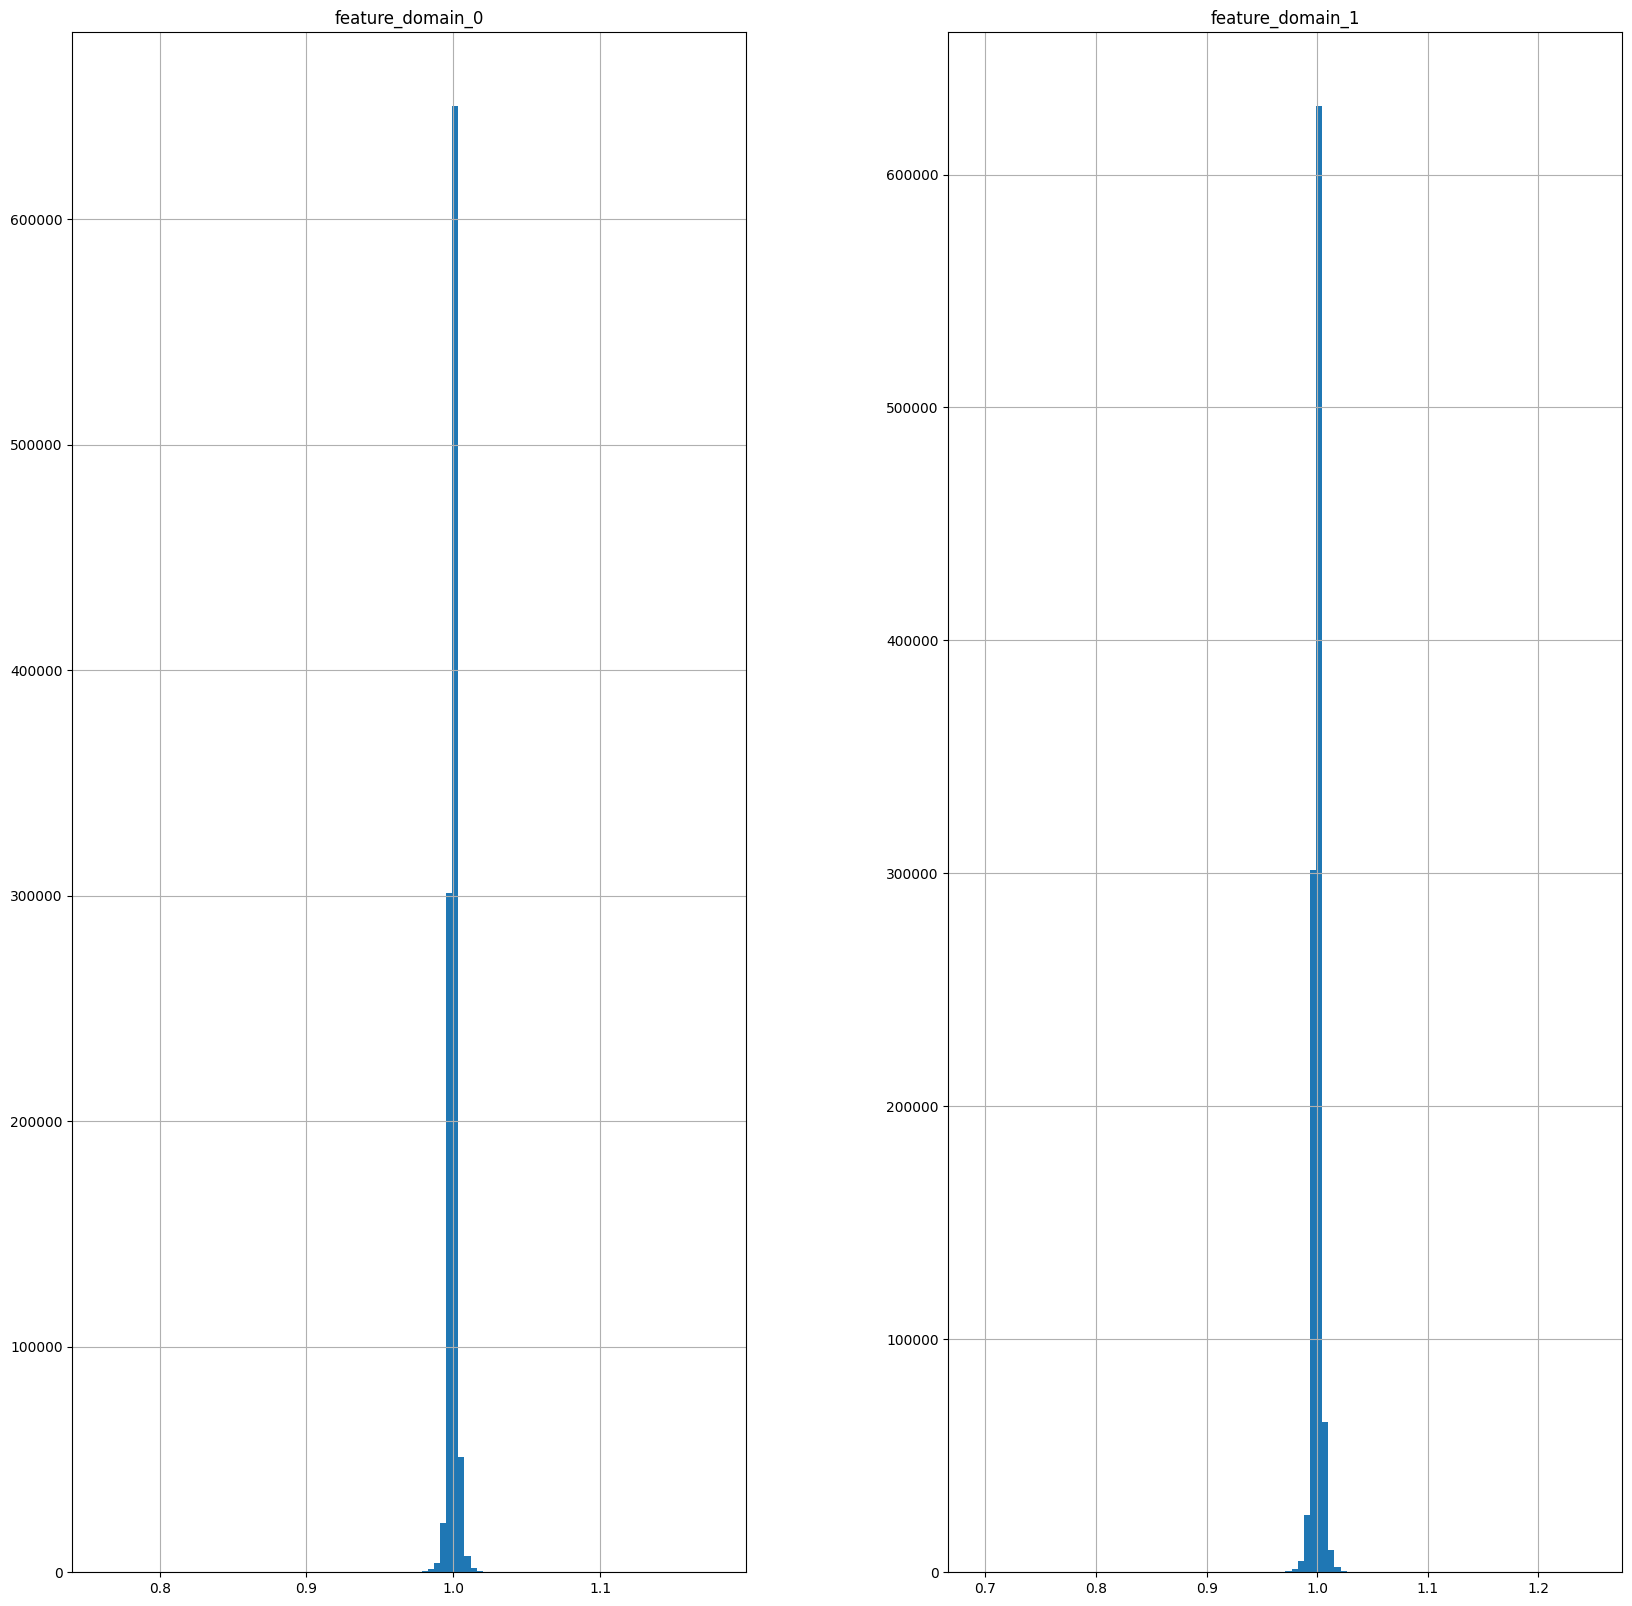

In [29]:
df[features].hist(bins=100, figsize=(20,20))

In [30]:
df_sample = df[df.type=="training"].sample(5000)
X = create_sequence(df_sample[features].values, config.block_size)
y = create_sequence_target(df_sample[config.target].values, config.block_size)

In [31]:
m = Transformer(config)
m=m.train()

In [32]:
EPOCHS = 1000
#BS = 10
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [33]:
loss_l = []

for i in range(EPOCHS):
    idx=torch.randint(0, X.size()[0], (config.batch_size,))
    #m.zero_grad()
    optimizer.zero_grad()
    out = m(X[idx])
    #out = m(src=X[idx].view(src_length, -1,1), tgt=y[idx].view(target_length, -1,1))
    #break
    loss = loss_fn(out.squeeze(),y[idx])
    #print("Loss", loss)
    loss.backward()
    optimizer.step()
    if i % 10==0:
        print("i", i, "Loss", loss)
        loss_l.append(loss.detach().numpy())

i 0 Loss tensor(0.9869, grad_fn=<MseLossBackward0>)
i 10 Loss tensor(0.9624, grad_fn=<MseLossBackward0>)
i 20 Loss tensor(0.9112, grad_fn=<MseLossBackward0>)
i 30 Loss tensor(0.8308, grad_fn=<MseLossBackward0>)
i 40 Loss tensor(0.7497, grad_fn=<MseLossBackward0>)
i 50 Loss tensor(0.6843, grad_fn=<MseLossBackward0>)
i 60 Loss tensor(0.6313, grad_fn=<MseLossBackward0>)
i 70 Loss tensor(0.5839, grad_fn=<MseLossBackward0>)
i 80 Loss tensor(0.5414, grad_fn=<MseLossBackward0>)
i 90 Loss tensor(0.5003, grad_fn=<MseLossBackward0>)
i 100 Loss tensor(0.4605, grad_fn=<MseLossBackward0>)
i 110 Loss tensor(0.4252, grad_fn=<MseLossBackward0>)
i 120 Loss tensor(0.3895, grad_fn=<MseLossBackward0>)
i 130 Loss tensor(0.3555, grad_fn=<MseLossBackward0>)
i 140 Loss tensor(0.3234, grad_fn=<MseLossBackward0>)
i 150 Loss tensor(0.2937, grad_fn=<MseLossBackward0>)
i 160 Loss tensor(0.2649, grad_fn=<MseLossBackward0>)
i 170 Loss tensor(0.2402, grad_fn=<MseLossBackward0>)
i 180 Loss tensor(0.2144, grad_fn=<MseL

In [34]:
m=m.eval()

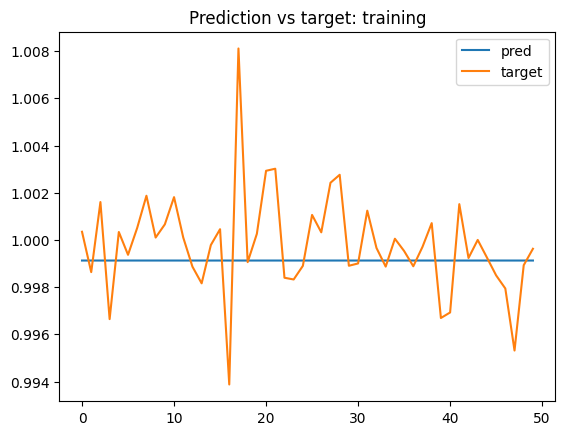

In [36]:
plt.plot(m(X[1:2]).squeeze().detach().numpy(), label="pred")
plt.plot(y[1:2].squeeze().detach().numpy(), label="target")
plt.title("Prediction vs target: training")
plt.legend()

In [18]:
df_sample_test = df[df.type=="validation"].sample(3000)
X_test = create_sequence(df_sample_test[features].values, config.block_size)
y_test = create_sequence_target(df_sample_test[config.target].values, config.block_size)

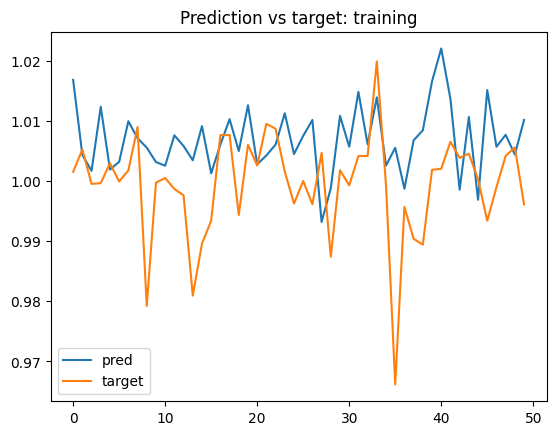

In [19]:
plt.plot(m(X_test[0:1]).squeeze().detach().numpy(), label="pred")
plt.plot(y_test[0:1].squeeze().detach().numpy(), label="target")
plt.title("Prediction vs target: training")
plt.legend()

In [142]:
with torch.no_grad():
    m=m.eval()
    print(m(X_test[0:1]))

tensor([[[-3.1943e-03],
         [-5.3176e-04],
         [ 3.4228e-03],
         [-4.4274e-03],
         [-1.3779e-03],
         [-3.5078e-03],
         [-1.8376e-03],
         [-1.7132e-03],
         [ 3.8879e-03],
         [-9.5292e-04],
         [ 1.8940e-03],
         [-2.6382e-03],
         [-4.1526e-03],
         [-8.1616e-04],
         [-3.8100e-03],
         [ 2.1800e-05],
         [-5.8857e-03],
         [-6.4929e-03],
         [-2.1056e-03],
         [ 2.9082e-03]]])


In [148]:
m(X[0:1])

tensor([[[-3.1943e-03],
         [-5.3176e-04],
         [ 3.4228e-03],
         [-4.4274e-03],
         [-1.3779e-03],
         [-3.5078e-03],
         [-1.8376e-03],
         [-1.7132e-03],
         [ 3.8879e-03],
         [-9.5292e-04],
         [ 1.8940e-03],
         [-2.6382e-03],
         [-4.1526e-03],
         [-8.1616e-04],
         [-3.8100e-03],
         [ 2.1800e-05],
         [-5.8857e-03],
         [-6.4929e-03],
         [-2.1056e-03],
         [ 2.9082e-03]]], grad_fn=<UnsafeViewBackward0>)

In [56]:
df_sample[features[:10]]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,2.001081,-0.001081,0.998920,1.001081,2.001081,-0.001081,0.998920,1.001081,1.999988,0.000012
1,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000
2,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000
3,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000
4,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
995,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000
996,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000
997,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000
998,2.000997,-0.000997,0.999004,1.000997,2.000997,-0.000997,0.999004,1.000997,1.999063,0.000937


In [57]:
len(df_sample[features].values)

1000

In [58]:
df_sample[features[:10]].values.shape

(1000, 10)

In [93]:
X = create_sequence(df_sample[features].values, config.block_size)
y = create_sequence_target(df_sample["target_20"].values, config.block_size)

In [94]:
X.size()

torch.Size([880, 120, 10])

In [95]:
y.size()

torch.Size([880, 120])

In [96]:
df_sample["target_20"]

0      0.005274
1      0.002691
2      0.002691
3      0.001800
4     -0.000273
         ...   
995   -0.008830
996   -0.007903
997   -0.007309
998   -0.006294
999   -0.005303
Name: target_20, Length: 1000, dtype: float64

In [97]:
y[0]

tensor([ 0.0053,  0.0027,  0.0027,  0.0018, -0.0003,  0.0012, -0.0012, -0.0019,
        -0.0019, -0.0019, -0.0021,  0.0004, -0.0013, -0.0022, -0.0011, -0.0012,
        -0.0012, -0.0010, -0.0039, -0.0039, -0.0059, -0.0061, -0.0061, -0.0079,
        -0.0082, -0.0068, -0.0051, -0.0050, -0.0084, -0.0084, -0.0093, -0.0111,
        -0.0113, -0.0110, -0.0121, -0.0120, -0.0133, -0.0153, -0.0125, -0.0125,
        -0.0104, -0.0094, -0.0094, -0.0055, -0.0064, -0.0072, -0.0076, -0.0067,
        -0.0033, -0.0035, -0.0025, -0.0032, -0.0023, -0.0024, -0.0035, -0.0038,
        -0.0025, -0.0006, -0.0040, -0.0033, -0.0086, -0.0143, -0.0160, -0.0144,
        -0.0131, -0.0129, -0.0117, -0.0081, -0.0081, -0.0098, -0.0092, -0.0095,
        -0.0114, -0.0108, -0.0079, -0.0076, -0.0076, -0.0076, -0.0066, -0.0073,
        -0.0020,  0.0038,  0.0056,  0.0027,  0.0027,  0.0025,  0.0008, -0.0039,
        -0.0054, -0.0038, -0.0047, -0.0038, -0.0019, -0.0019, -0.0049, -0.0033,
        -0.0033, -0.0002, -0.0002, -0.00

In [40]:
X.size()

torch.Size([111616, 10])

In [ ]:
# Add classification for the target
# Generate sequences


In [23]:
df[targets].describe()

,target_1,target_2,target_5,target_10,target_20,target_50,target_80,target_100
count,1.041228e+06,1.041228e+06,1.041228e+06,1.041228e+06,1.041228e+06,1.041228e+06,1.041228e+06,1.041228e+06
mean,2.928518e-06,6.171693e-06,1.589453e-05,3.068566e-05,5.665001e-05,1.305043e-04,2.042885e-04,2.518083e-04
std,1.515701e-03,2.223968e-03,3.633917e-03,5.199060e-03,7.347861e-03,1.129701e-02,1.400645e-02,1.547982e-02
min,-2.267778e-01,-2.746559e-01,-3.435378e-01,-4.023360e-01,-3.992186e-01,-3.978704e-01,-3.937287e-01,-3.927895e-01
25%,-2.364408e-04,-5.728145e-04,-1.245675e-03,-1.919242e-03,-2.879752e-03,-4.545950e-03,-5.682377e-03,-6.296281e-03
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.653224e-05,2.748295e-05,2.672116e-05
75%,2.496521e-04,5.885808e-04,1.271786e-03,1.985544e-03,2.943058e-03,4.698542e-03,5.873954e-03,6.504676e-03
max,1.137402e-01,1.647043e-01,2.259058e-01,3.097657e-01,3.122420e-01,4.451076e-01,4.489491e-01,4.581878e-01


array([[<AxesSubplot:title={'center':'target_1'}>,
        <AxesSubplot:title={'center':'target_2'}>,
        <AxesSubplot:title={'center':'target_5'}>],
       [<AxesSubplot:title={'center':'target_10'}>,
        <AxesSubplot:title={'center':'target_20'}>,
        <AxesSubplot:title={'center':'target_50'}>],
       [<AxesSubplot:title={'center':'target_80'}>,
        <AxesSubplot:title={'center':'target_100'}>, <AxesSubplot:>]],
      dtype=object)

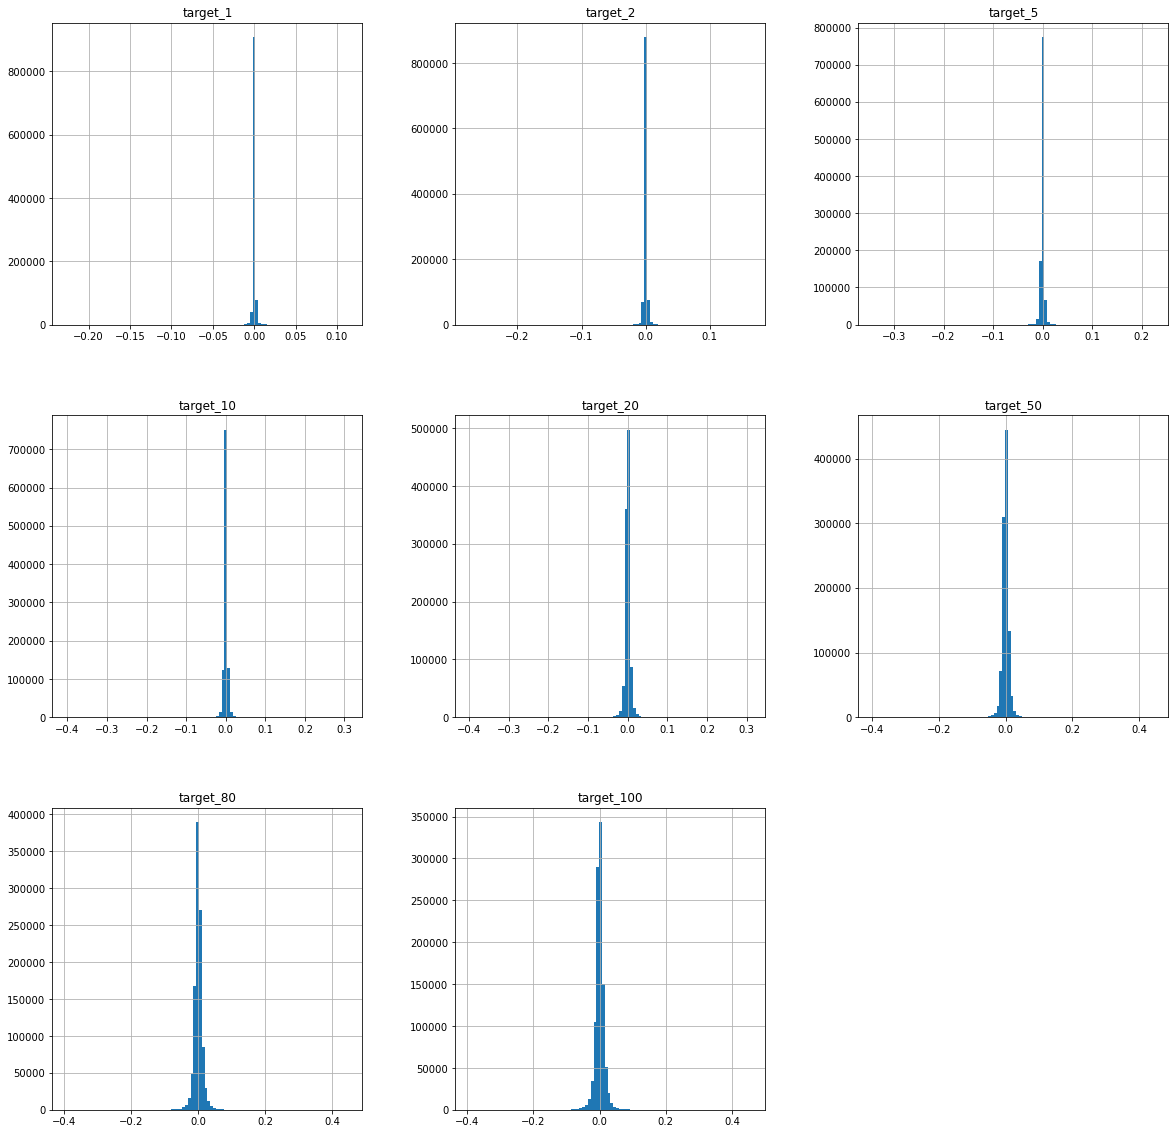

In [21]:
df[targets].hist(bins=100, figsize=(20,20))